# OTC Derivatives Margining Simulator
### A Monte Carlo Study of Liquidity Risk, Fire-Sale Dynamics, and Procyclical Margin Requirements

---

## Background and Motivation

The 2008 financial crisis exposed a critical weakness in over-the-counter (OTC) derivatives markets: bilateral credit exposure between counterparties was largely unhedged, and the failure of institutions such as Lehman Brothers and AIG created cascading losses across the financial system. In response, regulators introduced mandatory margining requirements for non-centrally-cleared derivatives under frameworks including **Basel III**, **EMIR** (Europe), and **Dodd-Frank** (US).

This project builds a Monte Carlo simulator to study how margin requirements interact with liquidity constraints, and what happens when institutions are forced to meet margin calls under stress.

## The Setup

Two parties enter an OTC forward contract:

- **Investor** (long the forward): holds limited cash ($L_0$) and illiquid assets ($A_0$). Subject to default.
- **Dealer** (short the forward): unlimited liquidity. Never defaults.

The contract's mark-to-market value $V_t = Q(S_t - K)$ changes daily as the asset price moves. Two types of margin protect the Dealer:

- **Initial Margin (IM):** posted upfront by the Investor; covers potential losses during the close-out window after default.
- **Variation Margin (VM):** exchanged daily to settle mark-to-market gains and losses.

When the Investor cannot meet a VM call from cash, it must sell illiquid assets at a discount — a **fire-sale**. If assets are exhausted, the Investor defaults due to liquidity.

## What This Notebook Demonstrates

| Section | Question |
|---------|----------|
| 1. Initial Margin | How large should the IM buffer be? |
| 2. Price Simulation | Arithmetic BM paths for the underlying asset |
| 3. Default Models | Exogenous-only vs liquidity-driven defaults |
| 4. Loss Distribution | What does the Dealer lose when the Investor defaults? |
| 5. Fire-Sale Costs | What liquidity burden does margining impose? |
| 6. Policy Analysis | How do margin rules affect the risk/liquidity trade-off? |
| 7. Procyclicality | How do stress-driven IM spikes amplify market instability? |

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

np.random.seed(42) #random seed for reproducibility

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

## Model Parameters

The Investor holds a long ATM forward on an asset priced at $S_0 = \$100$, with position size $Q = 1{,}000$ contracts and contract maturity of 300 trading days.

Price dynamics follow **arithmetic Brownian motion**: $S_{t+1} = S_t + \sigma_s\sqrt{dt}\cdot Z$, where $\sigma_s = \sigma \times S_0 = 20$ is the dollar volatility (translating 20% return vol into arithmetic BM units).

The Investor's balance sheet: $L_0 = \$16{,}000$ cash and $A_0 = \$6{,}000$ illiquid assets. Fire-sales occur at a 10% discount ($h = 0.10$). Annual default probability $PD = 1\%$.

In [6]:
S0 = 100.0            # Initial asset price
K  = 100.0            # Strike price (ATM forward)
Q  = 1000.0           # Position size (contracts)
sigma_s = 0.20 * S0   # Dollar volatility for arithmetic BM (= 20% return vol × S0)
MPOR = 10             # Margin Period of Risk (days)
PD   = 0.01           # Annual default probability
L0   = 20000.0        # Investor initial cash (must exceed IM ≈ $9,268)
A0   = 10000.0         # Investor initial illiquid assets
h    = 0.10           # Fire-sale discount
N    = 10000          # Monte Carlo paths

# Derived parameters
dt             = 1/252                         # Daily time step (trading days)
T_days         = 300                           # Simulation horizon
lambda_default = -np.log(1 - PD) / 252        # Daily default intensity

## 1. Initial Margin Derivation

The Initial Margin is the **99% Value-at-Risk** of the contract's mark-to-market change over the Margin Period of Risk (MPOR = 10 days). It is the buffer the Dealer holds to cover potential losses if the Investor defaults and the position cannot be closed immediately.

Under arithmetic BM the MTM change over $\Delta = MPOR \times dt$ is:
$$V_{t+\Delta} - V_t \sim N\!\left(0,\ Q^2\,\Delta\,\sigma_s^2\right)$$

The 99% VaR gives:
$$\text{IM} = z_{0.99} \cdot Q \cdot \sigma_s \cdot \sqrt{\Delta} = 2.326 \times 1000 \times 20 \times \sqrt{\tfrac{10}{252}} \approx \$9{,}268$$

> **Note:** No $S_0$ term — under arithmetic BM, $\sigma_s$ is already in dollar units, unlike GBM where dollar volatility is $\sigma \times S$.

In [7]:
delta_t = MPOR * dt
std_mtm = Q * sigma_s * np.sqrt(delta_t)   # Arithmetic BM: sigma_s = sigma*S0
z_99    = stats.norm.ppf(0.99)
IM      = z_99 * std_mtm

print(f'Initial Margin (99% VaR):    ${IM:,.2f}')
print(f'IM as % of notional:         {100*IM/(Q*K):.3f}%')
print(f'Investor cash after IM post: ${L0 - IM:,.2f}  (= L0 - IM)')

Initial Margin (99% VaR):    $9,268.39
IM as % of notional:         9.268%
Investor cash after IM post: $10,731.61  (= L0 - IM)


## 2. Asset Price Simulation

10,000 independent price paths are simulated using **arithmetic Brownian motion**:
$$S_{t+1} = S_t + \sigma_s\,\sqrt{dt}\cdot Z, \qquad Z \sim N(0,1)$$

The contract mark-to-market is $V_t = Q(S_t - K)$. Since the Investor is long, $V_t > 0$ when the price is above strike (Investor winning) and $V_t < 0$ when below (Investor owes the Dealer).

With $\sigma_s = 20$, the standard deviation of $S$ at $T = 300$ days is $\sigma_s\sqrt{T/252} \approx \$21.8$ — a realistic spread of outcomes around $S_0 = \$100$.

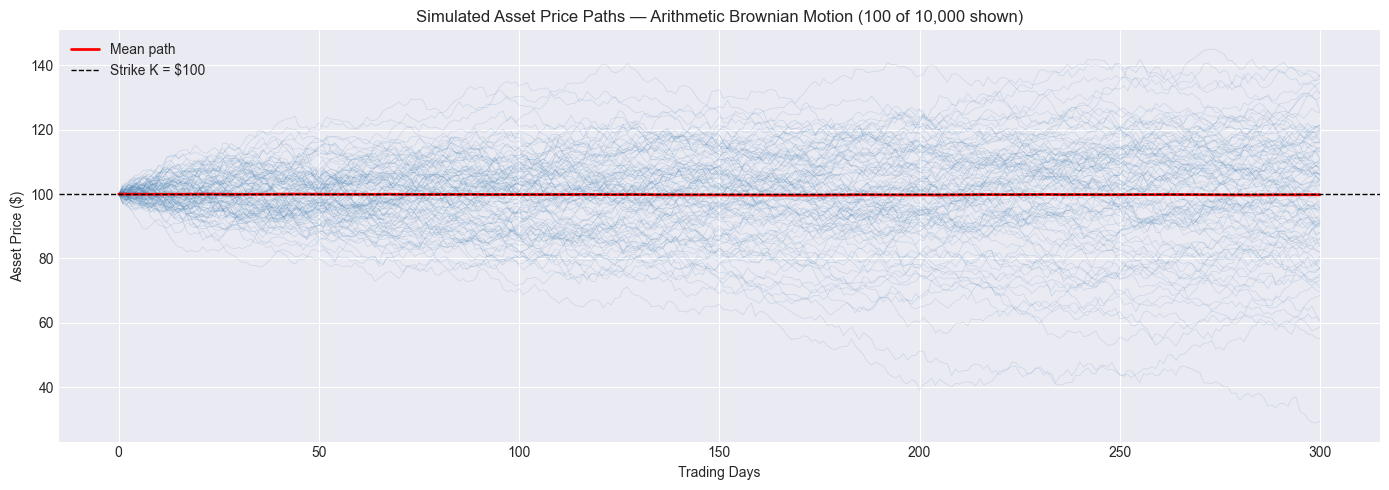

Price std at T=300d: $21.56  (theoretical: $21.82)
Paths with S < 0:    0 (0.00%)


In [8]:
S = np.zeros((N, T_days + 1))
S[:, 0] = S0
Z = np.random.normal(0, 1, (N, T_days))

for t in range(T_days):
    S[:, t + 1] = S[:, t] + sigma_s * np.sqrt(dt) * Z[:, t]

V = Q * (S - K)   # MTM: V_t = Q*(S_t - K)

# ── Plot 100 sample paths ──────────────────────────────────────────────
plt.figure(figsize=(14, 5))
days = np.arange(T_days + 1)
for i in range(100):
    plt.plot(days, S[i, :], alpha=0.2, linewidth=0.5, color='steelblue')
plt.plot(days, S.mean(axis=0), 'r-', linewidth=2, label='Mean path')
plt.axhline(K, color='black', linestyle='--', linewidth=1, label='Strike K = $100')
plt.xlabel('Trading Days')
plt.ylabel('Asset Price ($)')
plt.title('Simulated Asset Price Paths — Arithmetic Brownian Motion (100 of 10,000 shown)')
plt.legend()
plt.tight_layout()
plt.show()

print(f'Price std at T=300d: ${S[:,-1].std():,.2f}  (theoretical: ${sigma_s * np.sqrt(T_days*dt):,.2f})')
print(f'Paths with S < 0:    {(S[:,-1] < 0).sum()} ({100*(S[:,-1]<0).mean():.2f}%)')

## 3. Default Simulation

### 3a. Base Model — Exogenous Defaults Only

The simplest case: the Investor has unlimited cash and always meets margin calls. Default arrives as a Poisson process with daily intensity $\lambda = -\ln(1-PD)/252$, calibrated to a 1% annual default probability.

This gives the **credit-risk-only baseline** — Dealer losses come purely from adverse price moves during the MPOR after an unexpected default.

In [9]:
daily_pd = 1 - np.exp(-lambda_default)

u = np.random.uniform(0, 1, (N, T_days))
default_events = (u < daily_pd).astype(int)

defaults_base = np.zeros((N, T_days + 1), dtype=int)
for t in range(T_days):
    defaults_base[:, t + 1] = np.maximum(defaults_base[:, t], default_events[:, t])

n_defaults_base = defaults_base[:, -1].sum()
print(f'Exogenous defaults: {n_defaults_base:,}  ({100*n_defaults_base/N:.2f}%)')
print(f'Expected (annual PD={PD:.0%} over {T_days}d): ~{100*(1-(1-PD)**(T_days/252)):.2f}%')

Exogenous defaults: 140  (1.40%)
Expected (annual PD=1% over 300d): ~1.19%


### 3b. Liquidity Model — Fire-Sales and Endogenous Default

The Investor now has a real balance sheet — cash $L_0$ and illiquid assets $A_0$. When a daily VM call exceeds available cash, the Investor must sell illiquid assets at a 10% discount to raise the shortfall. If even that is insufficient, the Investor defaults due to liquidity exhaustion.

**Two causes of default:**
- **Exogenous:** the Poisson shock from the base model
- **Liquidity-driven:** cash and illiquid assets fully exhausted meeting VM calls

Once a default occurs, VM exchange is frozen for the 10-day MPOR window while the Dealer closes out the position.

In [10]:
defaults_fs      = np.zeros((N, T_days + 1), dtype=int)
cash             = np.zeros((N, T_days + 1))
illiquid         = np.zeros((N, T_days + 1))
fire_sale_costs  = np.zeros(N)
fire_sale_events = np.zeros(N)

cash[:, 0]     = L0 - IM    # IM posted at t=0; remainder is available cash
illiquid[:, 0] = A0
prev_V         = V[:, 0]
default_time   = np.full(N, -1)

for t in range(1, T_days + 1):
    cash[:, t]        = cash[:, t - 1]
    illiquid[:, t]    = illiquid[:, t - 1]
    defaults_fs[:, t] = defaults_fs[:, t - 1]

    # Exogenous defaults
    newly_defaulted = (defaults_base[:, t] == 1) & (defaults_fs[:, t - 1] == 0)
    defaults_fs[newly_defaulted, t] = 1
    default_time[newly_defaulted & (default_time == -1)] = t

    # MPOR freeze: no VM exchange while position is being closed out
    in_mpor = (default_time >= 0) & (t <= default_time + MPOR)
    active  = (defaults_fs[:, t] == 0) & ~in_mpor

    vm_payment = V[:, t] - prev_V

    # Investor receives cash when position gains
    cash[active & (vm_payment > 0), t] += vm_payment[active & (vm_payment > 0)]

    needs_pay = active & (vm_payment < 0)
    if needs_pay.any():
        payment      = -vm_payment[needs_pay]
        can_pay_cash = cash[needs_pay, t] >= payment

        # Pay from cash
        pays_cash = needs_pay.copy(); pays_cash[needs_pay] = can_pay_cash
        cash[pays_cash, t] -= payment[can_pay_cash]

        # Fire-sale: sell illiquid assets at discount to cover shortfall
        needs_fs = needs_pay.copy(); needs_fs[needs_pay] = ~can_pay_cash
        if needs_fs.any():
            shortfall      = payment[~can_pay_cash] - cash[needs_fs, t]
            assets_to_sell = shortfall / (1 - h)   # must sell more to net the shortfall
            fire_cost      = assets_to_sell * h

            fire_sale_costs[needs_fs]  += fire_cost
            fire_sale_events[needs_fs] += 1

            can_meet = illiquid[needs_fs, t] >= assets_to_sell

            meets = needs_fs.copy(); meets[needs_fs] = can_meet
            cash[meets, t]     = 0
            illiquid[meets, t] -= assets_to_sell[can_meet]

            liq_default = needs_fs.copy(); liq_default[needs_fs] = ~can_meet
            defaults_fs[liq_default, t] = 1
            default_time[liq_default & (default_time == -1)] = t

    prev_V = V[:, t]

# Return IM to non-defaulted paths at maturity
no_default = (defaults_fs[:, -1] == 0)
cash[no_default, -1] += IM

n_defaults_fs  = defaults_fs[:, -1].sum()
n_liq_defaults = n_defaults_fs - n_defaults_base

print(f'Total defaults:        {n_defaults_fs:,}  ({100*n_defaults_fs/N:.2f}%)')
print(f'  Exogenous:           {n_defaults_base:,}')
print(f'  Liquidity-driven:    {n_liq_defaults:,}')
print(f'Paths with fire-sales: {(fire_sale_events > 0).sum():,}  ({100*(fire_sale_events>0).sum()/N:.1f}%)')
print(f'Mean fire-sale cost:   ${fire_sale_costs.mean():,.2f} per path')

Total defaults:        3,632  (36.32%)
  Exogenous:           140
  Liquidity-driven:    3,492
Paths with fire-sales: 5,986  (59.9%)
Mean fire-sale cost:   $498.94 per path


## 4. Dealer Loss Distribution

When the Investor defaults at time $t$, the Dealer closes out at $t + MPOR$ and computes its loss:

$$\text{Loss} = \max\!\left(0,\ -V_{t+MPOR} - (IM + \text{last VM payment})\right)$$

- $-V_{t+MPOR}$: what the Investor owes the Dealer at close-out (positive when Investor is out-of-the-money)
- $IM$: the initial margin buffer posted at inception
- **Last VM payment** $= V_t - V_{t-1}$: the final daily cash flow exchanged before VM was frozen

The Dealer only loses money when the close-out exposure exceeds the collateral it holds. Both unconditional (all paths) and conditional (defaulted paths only) distributions are reported.

In [11]:
def calculate_losses(V, defaults, IM):
    """Compute Dealer loss for each defaulted path.

    Loss = max(0, -V_close - (IM + last_VM_payment))
    where V_close = V[t_default + MPOR] and last_VM_payment = V[t_default] - V[t_default-1].
    """
    losses = np.zeros(N)
    for i in range(N):
        default_times = np.where(defaults[i, :] == 1)[0]
        if len(default_times) > 0:
            t_default       = default_times[0]
            t_close         = min(t_default + MPOR, T_days)
            V_close         = V[i, t_close]
            t_prev          = max(t_default - 1, 0)
            last_VM_payment = V[i, t_default] - V[i, t_prev]
            collateral      = IM + last_VM_payment
            losses[i]       = max(0, -V_close - collateral)
    return losses

losses_base = calculate_losses(V, defaults_base, IM)
losses_fs   = calculate_losses(V, defaults_fs,   IM)

for label, losses in [('Base model (exogenous defaults only)', losses_base),
                       ('Liquidity model (fire-sales)',        losses_fs)]:
    cond = losses[losses > 0]
    print(f'\n{label}:')
    print(f'  Paths with loss:       {(losses>0).sum():,}  ({100*(losses>0).mean():.2f}%)')
    print(f'  Unconditional mean:    ${losses.mean():,.2f}')
    if len(cond):
        print(f'  Conditional mean:      ${cond.mean():,.2f}')
        print(f'  Conditional 95th pct:  ${np.percentile(cond, 95):,.2f}')
        print(f'  Conditional 99th pct:  ${np.percentile(cond, 99):,.2f}')
        print(f'  Max loss:              ${cond.max():,.2f}')


Base model (exogenous defaults only):
  Paths with loss:       43  (0.43%)
  Unconditional mean:    $45.91
  Conditional mean:      $10,677.22
  Conditional 95th pct:  $27,651.88
  Conditional 99th pct:  $32,304.02
  Max loss:              $34,453.09

Liquidity model (fire-sales):
  Paths with loss:       3,530  (35.30%)
  Unconditional mean:    $4,557.40
  Conditional mean:      $12,910.48
  Conditional 95th pct:  $19,615.40
  Conditional 99th pct:  $22,168.63
  Max loss:              $28,088.91


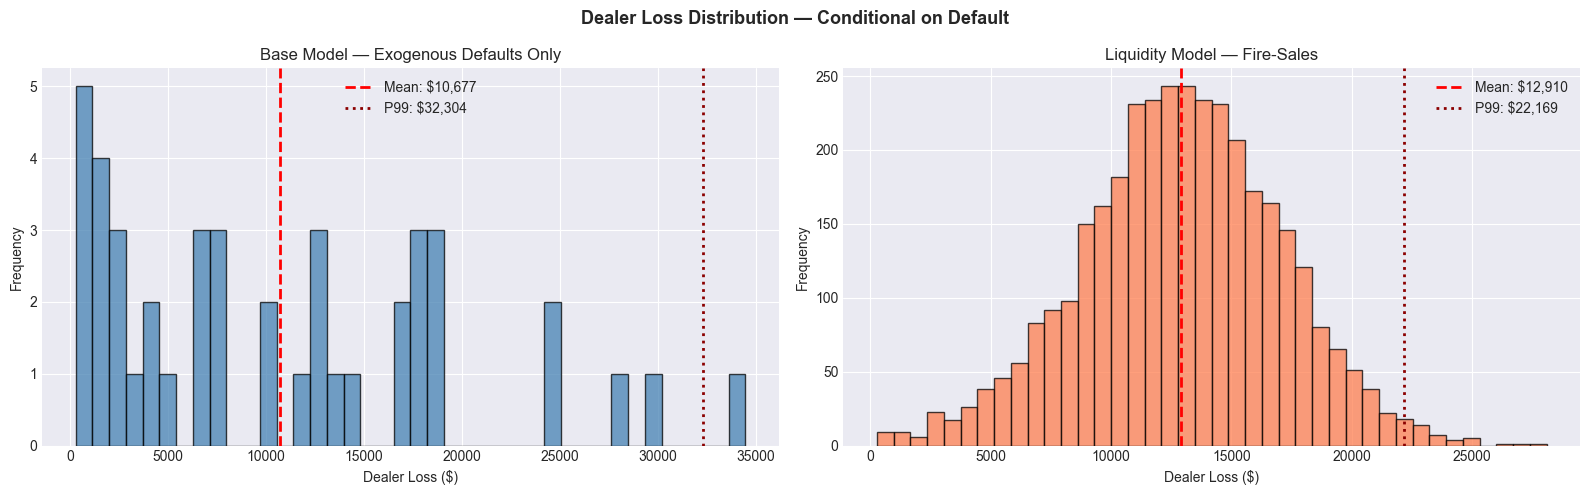

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

for ax, losses, title, colour in [
    (axes[0], losses_base, 'Base Model — Exogenous Defaults Only', 'steelblue'),
    (axes[1], losses_fs,   'Liquidity Model — Fire-Sales',         'coral'),
]:
    pos = losses[losses > 0]
    if len(pos):
        ax.hist(pos, bins=40, color=colour, edgecolor='black', alpha=0.75)
        ax.axvline(pos.mean(), color='red', linestyle='--', linewidth=2,
                   label=f'Mean: ${pos.mean():,.0f}')
        ax.axvline(np.percentile(pos, 99), color='darkred', linestyle=':', linewidth=2,
                   label=f'P99: ${np.percentile(pos,99):,.0f}')
    ax.set_xlabel('Dealer Loss ($)')
    ax.set_ylabel('Frequency')
    ax.set_title(title)
    ax.legend()

plt.suptitle('Dealer Loss Distribution — Conditional on Default', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

## 5. Fire-Sale Cost Analysis

Even when the Investor does not default, it may incur real wealth losses through fire-sales — selling illiquid assets below fair value purely to meet margin calls. This section quantifies that burden.

$$\text{Fire-sale cost per event} = \text{assets sold} \times h = \frac{\text{shortfall}}{1-h} \times h$$

This cost is borne entirely by the Investor and represents a permanent wealth transfer to buyers of the distressed assets.

In [13]:
print(f'Total fire-sale costs (all paths):      ${fire_sale_costs.sum():,.2f}')
print(f'Mean cost per path (unconditional):     ${fire_sale_costs.mean():,.2f}')
if (fire_sale_costs > 0).any():
    print(f'Mean cost per path (conditional):       ${fire_sale_costs[fire_sale_costs>0].mean():,.2f}')
    print(f'Max cost on any single path:            ${fire_sale_costs.max():,.2f}')
print(f'Paths with at least one fire-sale:      {(fire_sale_events>0).sum():,}  ({100*(fire_sale_events>0).mean():.1f}%)')
print(f'Mean fire-sale events per path:         {fire_sale_events.mean():.2f}')

Total fire-sale costs (all paths):      $4,989,368.46
Mean cost per path (unconditional):     $498.94
Mean cost per path (conditional):       $833.51
Max cost on any single path:            $1,464.07
Paths with at least one fire-sale:      5,986  (59.9%)
Mean fire-sale events per path:         5.09


## 6. Policy Analysis

The following four experiments each modify one dimension of the margin framework and re-run the simulation to isolate the effect. Each reveals a different facet of the fundamental tension: **tighter margins protect the Dealer but amplify the Investor's liquidity risk.**

### 6a. Initial Margin Multiplier

Setting $IM = k \times VaR_{99\%}$ for $k \in \{1.0,\ 1.5,\ 2.0,\ 2.5\}$.

Each value of $k$ requires a **full re-simulation** because higher IM reduces the Investor's starting cash ($L_0 - k \cdot IM$), directly changing how quickly fire-sales are triggered and how many paths default due to liquidity exhaustion.

  k  IM ($)  Default Rate (%)  Liq. Default Rate (%)  Mean Fire-Sale Cost  Mean Dealer Loss  P99 Dealer Loss
1.0  9268.0             36.32                  34.92               498.94           4557.40         20619.52
1.5 13903.0             48.19                  46.79               646.14           1934.39         12081.52
2.0 18537.0             61.53                  60.13               811.65            120.82          3497.17
2.5 23171.0             77.15                  75.75               972.48              0.13             0.00


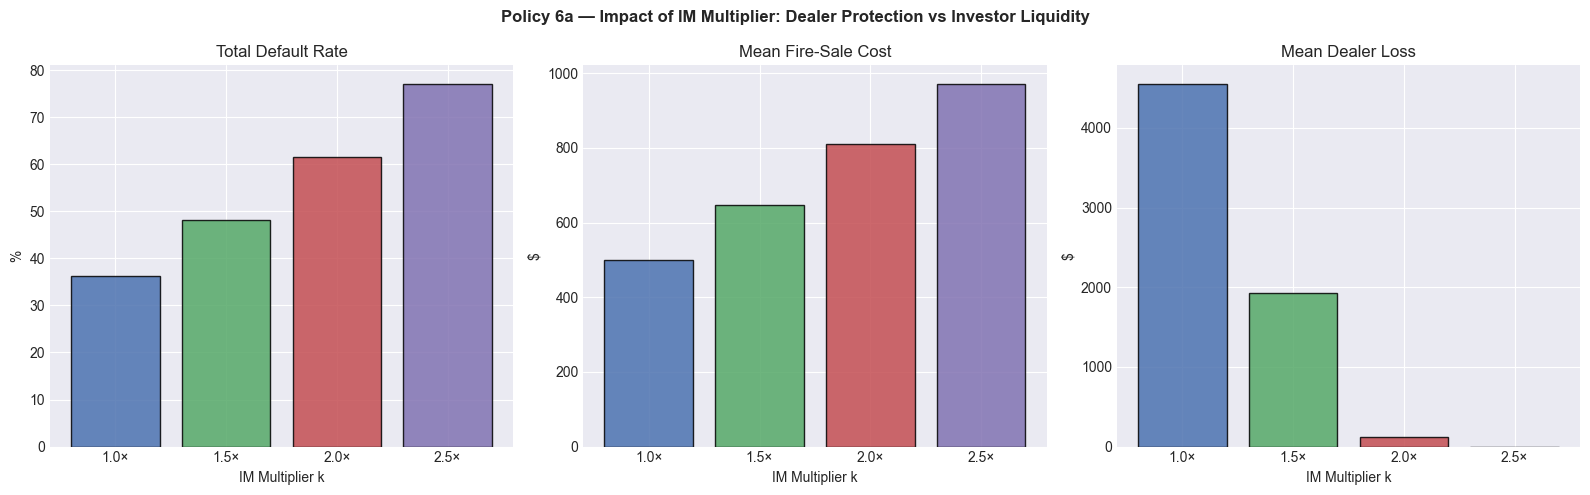

In [14]:
im_multipliers = [1.0, 1.5, 2.0, 2.5]
im_results = []

for mult in im_multipliers:
    im_test = IM * mult

    defaults_im   = np.zeros((N, T_days + 1), dtype=int)
    cash_im       = np.zeros((N, T_days + 1))
    illiquid_im   = np.zeros((N, T_days + 1))
    fire_costs_im = np.zeros(N)

    cash_im[:, 0]    = L0 - im_test
    illiquid_im[:, 0] = A0
    prev_V_im        = V[:, 0]
    default_time_im  = np.full(N, -1)

    for t in range(1, T_days + 1):
        cash_im[:, t]      = cash_im[:, t - 1]
        illiquid_im[:, t]  = illiquid_im[:, t - 1]
        defaults_im[:, t]  = defaults_im[:, t - 1]

        newly_defaulted = (defaults_base[:, t] == 1) & (defaults_im[:, t - 1] == 0)
        defaults_im[newly_defaulted, t] = 1
        default_time_im[newly_defaulted & (default_time_im == -1)] = t

        in_mpor_im = (default_time_im >= 0) & (t <= default_time_im + MPOR)
        active_im  = (defaults_im[:, t] == 0) & ~in_mpor_im

        vm_im = V[:, t] - prev_V_im
        cash_im[active_im & (vm_im > 0), t] += vm_im[active_im & (vm_im > 0)]

        needs_pay_im = active_im & (vm_im < 0)
        if needs_pay_im.any():
            pay_im       = -vm_im[needs_pay_im]
            can_cash_im  = cash_im[needs_pay_im, t] >= pay_im

            pc_im = needs_pay_im.copy(); pc_im[needs_pay_im] = can_cash_im
            cash_im[pc_im, t] -= pay_im[can_cash_im]

            nfs_im = needs_pay_im.copy(); nfs_im[needs_pay_im] = ~can_cash_im
            if nfs_im.any():
                short_im = pay_im[~can_cash_im] - cash_im[nfs_im, t]
                sell_im  = short_im / (1 - h)
                fire_costs_im[nfs_im] += sell_im * h

                cm_im   = illiquid_im[nfs_im, t] >= sell_im
                meets_im = nfs_im.copy(); meets_im[nfs_im] = cm_im
                cash_im[meets_im, t]     = 0
                illiquid_im[meets_im, t] -= sell_im[cm_im]

                ld_im = nfs_im.copy(); ld_im[nfs_im] = ~cm_im
                defaults_im[ld_im, t] = 1
                default_time_im[ld_im & (default_time_im == -1)] = t

        prev_V_im = V[:, t]

    no_def_im = (defaults_im[:, -1] == 0)
    cash_im[no_def_im, -1] += im_test

    losses_im = np.zeros(N)
    for i in range(N):
        dtimes = np.where(defaults_im[i, :] == 1)[0]
        if len(dtimes):
            t_def   = dtimes[0]
            t_close = min(t_def + MPOR, T_days)
            t_prev  = max(t_def - 1, 0)
            last_VM = V[i, t_def] - V[i, t_prev]
            losses_im[i] = max(0, -V[i, t_close] - (im_test + last_VM))

    im_results.append({
        'k':                    mult,
        'IM ($)':               round(im_test, 0),
        'Default Rate (%)':     round(100 * defaults_im[:, -1].sum() / N, 2),
        'Liq. Default Rate (%)':round(100 * (defaults_im[:, -1].sum() - n_defaults_base) / N, 2),
        'Mean Fire-Sale Cost':  round(fire_costs_im.mean(), 2),
        'Mean Dealer Loss':     round(losses_im.mean(), 2),
        'P99 Dealer Loss':      round(np.percentile(losses_im, 99), 2),
    })

df_im = pd.DataFrame(im_results)
print(df_im.to_string(index=False))

# ── Chart ──────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
ks     = [r['k'] for r in im_results]
labels = [f'{k}×' for k in ks]
colours = ['#4C72B0', '#55A868', '#C44E52', '#8172B2']

axes[0].bar(labels, [r['Default Rate (%)'] for r in im_results],     color=colours, edgecolor='black', alpha=0.85)
axes[0].set_title('Total Default Rate'); axes[0].set_xlabel('IM Multiplier k'); axes[0].set_ylabel('%')

axes[1].bar(labels, [r['Mean Fire-Sale Cost'] for r in im_results],  color=colours, edgecolor='black', alpha=0.85)
axes[1].set_title('Mean Fire-Sale Cost'); axes[1].set_xlabel('IM Multiplier k'); axes[1].set_ylabel('$')

axes[2].bar(labels, [r['Mean Dealer Loss'] for r in im_results],     color=colours, edgecolor='black', alpha=0.85)
axes[2].set_title('Mean Dealer Loss'); axes[2].set_xlabel('IM Multiplier k'); axes[2].set_ylabel('$')

plt.suptitle('Policy 6a — Impact of IM Multiplier: Dealer Protection vs Investor Liquidity', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

### 6b. Variation Margin Frequency

Comparing **daily** VM settlement against **weekly** (every 5 trading days). Under weekly settlement no cash changes hands between settlement days. On each settlement day the Investor pays the *net accumulated* MTM change since the last settlement — a lump sum that can be up to 5× larger than any single daily payment.

The Dealer accumulates exposure between settlements; the Investor faces fewer but larger funding events.

In [15]:
vm_frequency_weekly  = 5
defaults_weekly      = np.zeros((N, T_days + 1), dtype=int)
cash_weekly          = np.zeros((N, T_days + 1))
illiquid_weekly      = np.zeros((N, T_days + 1))
fire_sale_costs_weekly  = np.zeros(N)
fire_sale_events_weekly = np.zeros(N)

cash_weekly[:, 0]    = L0 - IM
illiquid_weekly[:, 0] = A0
default_time_weekly  = np.full(N, -1)
last_settlement_V    = V[:, 0].copy()
prev_settlement_V    = V[:, 0].copy()

for t in range(1, T_days + 1):
    cash_weekly[:, t]      = cash_weekly[:, t - 1]
    illiquid_weekly[:, t]  = illiquid_weekly[:, t - 1]
    defaults_weekly[:, t]  = defaults_weekly[:, t - 1]

    newly_defaulted = (defaults_base[:, t] == 1) & (defaults_weekly[:, t - 1] == 0)
    defaults_weekly[newly_defaulted, t] = 1
    default_time_weekly[newly_defaulted & (default_time_weekly == -1)] = t

    in_mpor_weekly = (default_time_weekly >= 0) & (t <= default_time_weekly + MPOR)

    if t % vm_frequency_weekly == 0:
        vm_payment = V[:, t] - last_settlement_V   # net move since last settlement
        active     = (defaults_weekly[:, t] == 0) & ~in_mpor_weekly

        cash_weekly[active & (vm_payment > 0), t] += vm_payment[active & (vm_payment > 0)]

        needs_pay = active & (vm_payment < 0)
        if needs_pay.any():
            payment      = -vm_payment[needs_pay]
            can_pay_cash = cash_weekly[needs_pay, t] >= payment

            pays_cash = needs_pay.copy(); pays_cash[needs_pay] = can_pay_cash
            cash_weekly[pays_cash, t] -= payment[can_pay_cash]

            needs_fs = needs_pay.copy(); needs_fs[needs_pay] = ~can_pay_cash
            if needs_fs.any():
                shortfall      = payment[~can_pay_cash] - cash_weekly[needs_fs, t]
                assets_to_sell = shortfall / (1 - h)
                fire_sale_costs_weekly[needs_fs]  += assets_to_sell * h
                fire_sale_events_weekly[needs_fs] += 1

                can_meet = illiquid_weekly[needs_fs, t] >= assets_to_sell
                meets = needs_fs.copy(); meets[needs_fs] = can_meet
                cash_weekly[meets, t]     = 0
                illiquid_weekly[meets, t] -= assets_to_sell[can_meet]

                liq_default = needs_fs.copy(); liq_default[needs_fs] = ~can_meet
                defaults_weekly[liq_default, t] = 1
                default_time_weekly[liq_default & (default_time_weekly == -1)] = t

        settled = (defaults_weekly[:, t] == 0) & ~in_mpor_weekly
        prev_settlement_V[settled] = last_settlement_V[settled]
        last_settlement_V[settled] = V[settled, t]

no_default_weekly = (defaults_weekly[:, -1] == 0)
cash_weekly[no_default_weekly, -1] += IM

losses_weekly = np.zeros(N)
for i in range(N):
    dtimes = np.where(defaults_weekly[i, :] == 1)[0]
    if len(dtimes):
        t_def         = dtimes[0]
        t_close       = min(t_def + MPOR, T_days)
        last_VM_payment = last_settlement_V[i] - prev_settlement_V[i]
        losses_weekly[i] = max(0, -V[i, t_close] - (IM + last_VM_payment))

print(f'{"":30s}  {"Daily VM":>12}  {"Weekly VM":>12}')
print(f'{"Default rate":30s}  {100*defaults_fs[:,-1].sum()/N:>11.2f}%  {100*defaults_weekly[:,-1].sum()/N:>11.2f}%')
print(f'{"Mean dealer loss":30s}  ${losses_fs.mean():>11,.2f}  ${losses_weekly.mean():>11,.2f}')
print(f'{"Mean fire-sale cost":30s}  ${fire_sale_costs.mean():>11,.2f}  ${fire_sale_costs_weekly.mean():>11,.2f}')
print(f'{"Fire-sale events per path":30s}  {fire_sale_events.mean():>12.2f}  {fire_sale_events_weekly.mean():>12.2f}')

                                    Daily VM     Weekly VM
Default rate                          36.32%        34.26%
Mean dealer loss                $   4,557.40  $   4,656.02
Mean fire-sale cost             $     498.94  $     505.41
Fire-sale events per path               5.09          2.34


### 6c. Margin Period of Risk

Testing MPOR $\in \{10,\ 5,\ 3\}$ days. A shorter MPOR reduces the IM requirement (the buffer covers fewer days of potential price movement), freeing up liquidity for the Investor. But the Dealer closes out faster with less collateral, potentially increasing losses if prices move sharply.

Each MPOR scenario uses **independently simulated price paths and default draws** to avoid confounding different IM levels with the same random outcomes.

In [16]:
mpor_values = [10, 5, 3]
mpor_results = []

for mpor in mpor_values:
    # Independent random seed per MPOR scenario
    rng = np.random.RandomState(seed=42 + mpor * 100)

    delta_t_test = mpor * dt
    im_test = stats.norm.ppf(0.99) * Q * sigma_s * np.sqrt(delta_t_test)

    # --- Re-simulate price paths ---
    S_m = np.zeros((N, T_days + 1)); S_m[:, 0] = S0
    Z_m = rng.normal(0, 1, (N, T_days))
    for t in range(T_days):
        S_m[:, t+1] = S_m[:, t] + sigma_s * np.sqrt(dt) * Z_m[:, t]  # arithmetic BM
    V_m = Q * (S_m - K)

    # --- Re-simulate exogenous defaults ---
    u_m = rng.uniform(0, 1, (N, T_days))
    def_events_m = (u_m < daily_pd).astype(int)
    defaults_base_m = np.zeros((N, T_days + 1), dtype=int)
    for t in range(T_days):
        defaults_base_m[:, t+1] = np.maximum(defaults_base_m[:, t], def_events_m[:, t])

    # --- Full liquidity simulation ---
    defaults_m = np.zeros((N, T_days + 1), dtype=int)
    cash_m = np.zeros((N, T_days + 1))
    illiquid_m = np.zeros((N, T_days + 1))
    fire_costs_m = np.zeros(N)

    cash_m[:, 0] = L0 - im_test
    illiquid_m[:, 0] = A0
    prev_V_m = V_m[:, 0]
    default_time_m = np.full(N, -1)

    for t in range(1, T_days + 1):
        cash_m[:, t] = cash_m[:, t - 1]
        illiquid_m[:, t] = illiquid_m[:, t - 1]
        defaults_m[:, t] = defaults_m[:, t - 1]

        newly_defaulted = (defaults_base_m[:, t] == 1) & (defaults_m[:, t - 1] == 0)
        defaults_m[newly_defaulted, t] = 1
        default_time_m[newly_defaulted & (default_time_m == -1)] = t

        in_mpor_m = (default_time_m >= 0) & (t <= default_time_m + mpor)
        active_m = (defaults_m[:, t] == 0) & ~in_mpor_m

        vm_m = V_m[:, t] - prev_V_m
        cash_m[active_m & (vm_m > 0), t] += vm_m[active_m & (vm_m > 0)]

        needs_pay_m = active_m & (vm_m < 0)
        if needs_pay_m.any():
            pay_m = -vm_m[needs_pay_m]
            can_cash_m = cash_m[needs_pay_m, t] >= pay_m

            pc_m = needs_pay_m.copy(); pc_m[needs_pay_m] = can_cash_m
            cash_m[pc_m, t] -= pay_m[can_cash_m]

            nfs_m = needs_pay_m.copy(); nfs_m[needs_pay_m] = ~can_cash_m
            if nfs_m.any():
                short_m = pay_m[~can_cash_m] - cash_m[nfs_m, t]
                sell_m = short_m / (1 - h)
                fire_costs_m[nfs_m] += sell_m * h

                cm_m = illiquid_m[nfs_m, t] >= sell_m
                meets_m = nfs_m.copy(); meets_m[nfs_m] = cm_m
                cash_m[meets_m, t] = 0
                illiquid_m[meets_m, t] -= sell_m[cm_m]

                ld_m = nfs_m.copy(); ld_m[nfs_m] = ~cm_m
                defaults_m[ld_m, t] = 1
                default_time_m[ld_m & (default_time_m == -1)] = t

        prev_V_m = V_m[:, t]

    no_def_m = (defaults_m[:, -1] == 0)
    cash_m[no_def_m, -1] += im_test

    # Loss calculation using MPOR-specific value
    # last_VM = last payment exchanged = V[t_def] - V[t_def-1]
    losses_m = np.zeros(N)
    for i in range(N):
        dtimes = np.where(defaults_m[i, :] == 1)[0]
        if len(dtimes) > 0:
            t_def = dtimes[0]
            t_close = min(t_def + mpor, T_days)
            V_close = V_m[i, t_close]
            t_prev_m = max(t_def - 1, 0)
            last_VM = V_m[i, t_def] - V_m[i, t_prev_m]  # payment, not level
            losses_m[i] = max(0, -V_close - (im_test + last_VM))

    mpor_results.append({
        'MPOR (days)': mpor,
        'IM ($)': round(im_test, 2),
        'Default Rate (%)': round(100 * defaults_m[:, -1].sum() / N, 2),
        'Mean Fire-Sale Cost': round(fire_costs_m.mean(), 2),
        'Mean Dealer Loss': round(losses_m.mean(), 4),
        'P99 Dealer Loss': round(np.percentile(losses_m, 99), 4),
    })

df_mpor = pd.DataFrame(mpor_results)
print(df_mpor.to_string(index=False))


 MPOR (days)  IM ($)  Default Rate (%)  Mean Fire-Sale Cost  Mean Dealer Loss  P99 Dealer Loss
          10 9268.39             35.07               493.45         4425.7391       20624.3712
           5 6553.74             29.51               414.04         5262.1230       24091.3692
           3 5076.51             26.89               377.11         5532.4223       25885.8478


### 6d. Illiquid Assets as VM Collateral

Instead of selling illiquid assets at a discount (**fire-sale**), the Investor **pledges** them directly to the Dealer to meet VM calls. The Dealer applies the same 10% haircut, but no market transaction occurs — eliminating the fire-sale discount cost for the Investor.

The Dealer accumulates pledged assets as collateral. On default, total collateral held by the Dealer is:
$$\text{Collateral} = IM + \text{last VM payment} + \underbrace{\sum \text{shortfalls covered by pledges}}_{\text{cumulative pledged value}}$$

> **Key insight:** pledging shifts risk from Investor to Dealer. The Dealer now holds illiquid assets it must liquidate at the same 10% haircut on default. Risk is redistributed, not eliminated.

In [17]:
h_col = 0.10

defaults_col              = np.zeros((N, T_days + 1), dtype=int)
cash_col                  = np.zeros((N, T_days + 1))
illiquid_col              = np.zeros((N, T_days + 1))
collateral_posted_illiquid = np.zeros(N)   # gross face value pledged to Dealer
cum_pledged_shortfall      = np.zeros(N)   # effective recovery value Dealer holds

cash_col[:, 0]    = L0 - IM
illiquid_col[:, 0] = A0
prev_V_col        = V[:, 0]
default_time_col  = np.full(N, -1)

for t in range(1, T_days + 1):
    cash_col[:, t]     = cash_col[:, t - 1]
    illiquid_col[:, t] = illiquid_col[:, t - 1]
    defaults_col[:, t] = defaults_col[:, t - 1]

    newly_defaulted = (defaults_base[:, t] == 1) & (defaults_col[:, t - 1] == 0)
    defaults_col[newly_defaulted, t] = 1
    default_time_col[newly_defaulted & (default_time_col == -1)] = t

    in_mpor_col = (default_time_col >= 0) & (t <= default_time_col + MPOR)
    active_col  = (defaults_col[:, t] == 0) & ~in_mpor_col

    vm_col = V[:, t] - prev_V_col
    cash_col[active_col & (vm_col > 0), t] += vm_col[active_col & (vm_col > 0)]

    needs_pay_col = active_col & (vm_col < 0)
    if needs_pay_col.any():
        pay_col      = -vm_col[needs_pay_col]
        can_cash_col = cash_col[needs_pay_col, t] >= pay_col

        pc_col = needs_pay_col.copy(); pc_col[needs_pay_col] = can_cash_col
        cash_col[pc_col, t] -= pay_col[can_cash_col]

        needs_pledge = needs_pay_col.copy(); needs_pledge[needs_pay_col] = ~can_cash_col
        if needs_pledge.any():
            shortfall_col    = pay_col[~can_cash_col] - cash_col[needs_pledge, t]
            assets_to_pledge = shortfall_col / (1 - h_col)   # face to pledge
            can_pledge       = illiquid_col[needs_pledge, t] >= assets_to_pledge

            pledges = needs_pledge.copy(); pledges[needs_pledge] = can_pledge
            illiquid_col[pledges, t]            -= assets_to_pledge[can_pledge]
            collateral_posted_illiquid[pledges] += assets_to_pledge[can_pledge]
            cum_pledged_shortfall[pledges]      += shortfall_col[can_pledge]
            cash_col[pledges, t]                 = 0

            liq_def_col = needs_pledge.copy(); liq_def_col[needs_pledge] = ~can_pledge
            defaults_col[liq_def_col, t] = 1
            default_time_col[liq_def_col & (default_time_col == -1)] = t

    prev_V_col = V[:, t]

no_default_col = (defaults_col[:, -1] == 0)
cash_col[no_default_col, -1] += IM

# Correct loss: Dealer holds IM + last VM + cumulative pledged value
losses_col = np.zeros(N)
for i in range(N):
    dtimes = np.where(defaults_col[i, :] == 1)[0]
    if len(dtimes):
        t_def           = dtimes[0]
        t_close         = min(t_def + MPOR, T_days)
        t_prev          = max(t_def - 1, 0)
        last_VM_payment = V[i, t_def] - V[i, t_prev]
        collateral_full = IM + last_VM_payment + cum_pledged_shortfall[i]
        losses_col[i]   = max(0, -V[i, t_close] - collateral_full)

print(f'{"":35s}  {"Baseline (fire-sales)":>22}  {"Illiquid collateral":>22}')
print(f'{"Default rate":35s}  {100*defaults_fs[:,-1].sum()/N:>21.2f}%  {100*defaults_col[:,-1].sum()/N:>21.2f}%')
print(f'{"Mean fire-sale cost":35s}  ${fire_sale_costs.mean():>21,.2f}  ${"0.00":>21}')
print(f'{"Mean illiquid pledged (gross face)":35s}  {"N/A":>22}  ${collateral_posted_illiquid.mean():>21,.2f}')
print(f'{"Mean cumulative pledged value":35s}  {"N/A":>22}  ${cum_pledged_shortfall.mean():>21,.2f}')
print(f'{"Mean dealer loss":35s}  ${losses_fs.mean():>21,.2f}  ${losses_col.mean():>21,.2f}')

                                      Baseline (fire-sales)     Illiquid collateral
Default rate                                         36.32%                  36.32%
Mean fire-sale cost                  $               498.94  $                 0.00
Mean illiquid pledged (gross face)                      N/A  $             4,405.79
Mean cumulative pledged value                           N/A  $             3,965.21
Mean dealer loss                     $             4,557.40  $             1,761.81


## 7. Procyclical Margins and Systemic Risk

### 7a. Procyclical Initial Margin

When markets fall, volatility rises — and if IM is recalculated from current (stressed) volatility, the IM requirement spikes precisely when the Investor is already under pressure from falling prices. This forces additional margin posting at the worst possible time, draining cash and triggering more fire-sales.

**Regime-switching volatility:** each path starts in a low-vol regime ($\sigma = 15\%$). If the price drops more than 2% of $S_0$ on any day, that path switches to high vol ($\sigma = 30\%$) the following day, then reverts.

**Procyclical IM:** recalculated daily from current vol — doubling during stress. On any day where vol spikes, the Investor must post the incremental IM top-up *in addition to* the daily VM payment.

> **Through-the-cycle (TTC) alternative:** using long-run average vol for IM avoids spikes at the cost of slightly underestimating risk in calm periods — the standard regulatory compromise.

In [18]:
vol_low    = 0.15;  vol_low_s  = vol_low  * S0
vol_high   = 0.30;  vol_high_s = vol_high * S0

S_vol    = np.zeros((N, T_days + 1))
vol_path = np.zeros((N, T_days + 1))
S_vol[:, 0]    = S0
vol_path[:, 0] = vol_low

for t in range(T_days):
    Z_vol  = np.random.normal(0, 1, N)
    dS_vol = vol_path[:, t] * S0 * np.sqrt(dt) * Z_vol
    S_vol[:, t + 1]    = S_vol[:, t] + dS_vol
    vol_path[:, t + 1] = vol_low
    vol_path[dS_vol / S0 < -0.02, t + 1] = vol_high

V_vol = Q * (S_vol - K)

IM_procyclical  = stats.norm.ppf(0.99) * Q * vol_path * S0 * np.sqrt(delta_t)
IM_baseline_low = stats.norm.ppf(0.99) * Q * vol_low_s  * np.sqrt(delta_t)
IM_stress_high  = stats.norm.ppf(0.99) * Q * vol_high_s * np.sqrt(delta_t)
total_im_topup  = np.maximum(0, np.diff(IM_procyclical, axis=1)).sum(axis=1)

print(f'Normal-regime IM  (vol={vol_low:.0%}): ${IM_baseline_low:,.2f}')
print(f'Stress-regime IM  (vol={vol_high:.0%}): ${IM_stress_high:,.2f}  (+{100*(IM_stress_high/IM_baseline_low-1):.0f}%)')
print(f'Mean total IM top-up per path:  ${total_im_topup.mean():,.2f}')
print(f'99th pct IM top-up:             ${np.percentile(total_im_topup, 99):,.2f}')
print(f'Time in high-vol regime:        {100*(vol_path > 0.2).mean():.1f}%')

defaults_procyc   = np.zeros((N, T_days + 1), dtype=int)
cash_procyc       = np.zeros((N, T_days + 1))
illiquid_procyc   = np.zeros((N, T_days + 1))
fire_costs_procyc = np.zeros(N)

cash_procyc[:, 0]    = L0 - IM_procyclical[:, 0]
illiquid_procyc[:, 0] = A0
prev_V_procyc        = V_vol[:, 0]
default_time_procyc  = np.full(N, -1)
im_held_procyc       = IM_procyclical[:, 0].copy()

u_pc = np.random.uniform(0, 1, (N, T_days))
defaults_base_pc = np.zeros((N, T_days + 1), dtype=int)
for t in range(T_days):
    defaults_base_pc[:, t+1] = np.maximum(defaults_base_pc[:, t],
                                           (u_pc[:, t] < daily_pd).astype(int))

for t in range(1, T_days + 1):
    cash_procyc[:, t]      = cash_procyc[:, t - 1]
    illiquid_procyc[:, t]  = illiquid_procyc[:, t - 1]
    defaults_procyc[:, t]  = defaults_procyc[:, t - 1]

    newly_defaulted = (defaults_base_pc[:, t] == 1) & (defaults_procyc[:, t - 1] == 0)
    defaults_procyc[newly_defaulted, t] = 1
    default_time_procyc[newly_defaulted & (default_time_procyc == -1)] = t

    in_mpor_pc = (default_time_procyc >= 0) & (t <= default_time_procyc + MPOR)
    active_pc  = (defaults_procyc[:, t] == 0) & ~in_mpor_pc

    vm_pc = V_vol[:, t] - prev_V_procyc
    cash_procyc[active_pc & (vm_pc > 0), t] += vm_pc[active_pc & (vm_pc > 0)]

    im_topup_t         = np.maximum(0, IM_procyclical[:, t] - im_held_procyc)
    total_cash_demand  = np.zeros(N)
    total_cash_demand[active_pc & (vm_pc < 0)] += (-vm_pc)[active_pc & (vm_pc < 0)]
    total_cash_demand[active_pc]               += im_topup_t[active_pc]

    needs_pay_pc = active_pc & (total_cash_demand > 0)
    if needs_pay_pc.any():
        demand      = total_cash_demand[needs_pay_pc]
        can_cash_pc = cash_procyc[needs_pay_pc, t] >= demand

        pays_pc = needs_pay_pc.copy(); pays_pc[needs_pay_pc] = can_cash_pc
        cash_procyc[pays_pc, t] -= demand[can_cash_pc]
        im_held_procyc[pays_pc]  = IM_procyclical[pays_pc, t]

        nfs_pc = needs_pay_pc.copy(); nfs_pc[needs_pay_pc] = ~can_cash_pc
        if nfs_pc.any():
            short_pc = demand[~can_cash_pc] - cash_procyc[nfs_pc, t]
            sell_pc  = short_pc / (1 - h)
            fire_costs_procyc[nfs_pc] += sell_pc * h

            cm_pc   = illiquid_procyc[nfs_pc, t] >= sell_pc
            meets_pc = nfs_pc.copy(); meets_pc[nfs_pc] = cm_pc
            cash_procyc[meets_pc, t]     = 0
            illiquid_procyc[meets_pc, t] -= sell_pc[cm_pc]
            im_held_procyc[meets_pc]      = IM_procyclical[meets_pc, t]

            ld_pc = nfs_pc.copy(); ld_pc[nfs_pc] = ~cm_pc
            defaults_procyc[ld_pc, t] = 1
            default_time_procyc[ld_pc & (default_time_procyc == -1)] = t

    prev_V_procyc = V_vol[:, t]

no_def_pc = (defaults_procyc[:, -1] == 0)
cash_procyc[no_def_pc, -1] += im_held_procyc[no_def_pc]

ttc_im = stats.norm.ppf(0.99) * Q * vol_path.mean() * S0 * np.sqrt(delta_t)
print(f'\n{"":35s}  {"Fixed-vol baseline":>20}  {"Procyclical IM":>20}')
print(f'{"Default rate":35s}  {100*defaults_fs[:,-1].sum()/N:>19.2f}%  {100*defaults_procyc[:,-1].sum()/N:>19.2f}%')
print(f'{"Mean fire-sale cost":35s}  ${fire_sale_costs.mean():>19,.2f}  ${fire_costs_procyc.mean():>19,.2f}')
print(f'\nThrough-the-cycle IM (mean vol {vol_path.mean()*100:.1f}%): ${ttc_im:,.2f}')

Normal-regime IM  (vol=15%): $6,951.29
Stress-regime IM  (vol=30%): $13,902.59  (+100%)
Mean total IM top-up per path:  $34,959.45
99th pct IM top-up:             $76,464.23
Time in high-vol regime:        2.0%

                                       Fixed-vol baseline        Procyclical IM
Default rate                                       36.32%                79.09%
Mean fire-sale cost                  $             498.94  $           1,037.06

Through-the-cycle IM (mean vol 15.3%): $7,087.36


### 7b. Systemic Liquidity Externality

When many institutions simultaneously fire-sell the same illiquid assets, their combined selling pressure drives prices down — making each subsequent sale more costly. This is a **negative externality**: individually rational behaviour aggregates into a system-wide outcome worse than any individual's risk model would predict.

The fire-sale haircut becomes endogenous:
$$h_t = \min\!\left(h_0 \cdot \bigl(1 + \theta \cdot f_{t-1}\bigr),\ 0.50\right)$$

where $f_{t-1}$ is the fraction of the population fire-selling *yesterday* (lagged one day — yesterday's selling has already moved today's market prices), $h_0 = 10\%$, and $\theta = 2$.

This creates a **liquidity spiral**: fire-sales raise $h$ → next sellers must sell more assets to raise the same cash → more defaults → more fire-sales.


Endogenous fire-sale discount: h_t = 10% x (1 + 2 x frac_selling_{t-1})
  Max h reached: 10.7%  |  Mean h (fire-sale days): 10.3%

  Baseline model:  fire-sale cost $498.94/path  |  defaults 36.32%
Systemic model                  fire-sale cost $520.25/path  |  defaults 36.39%


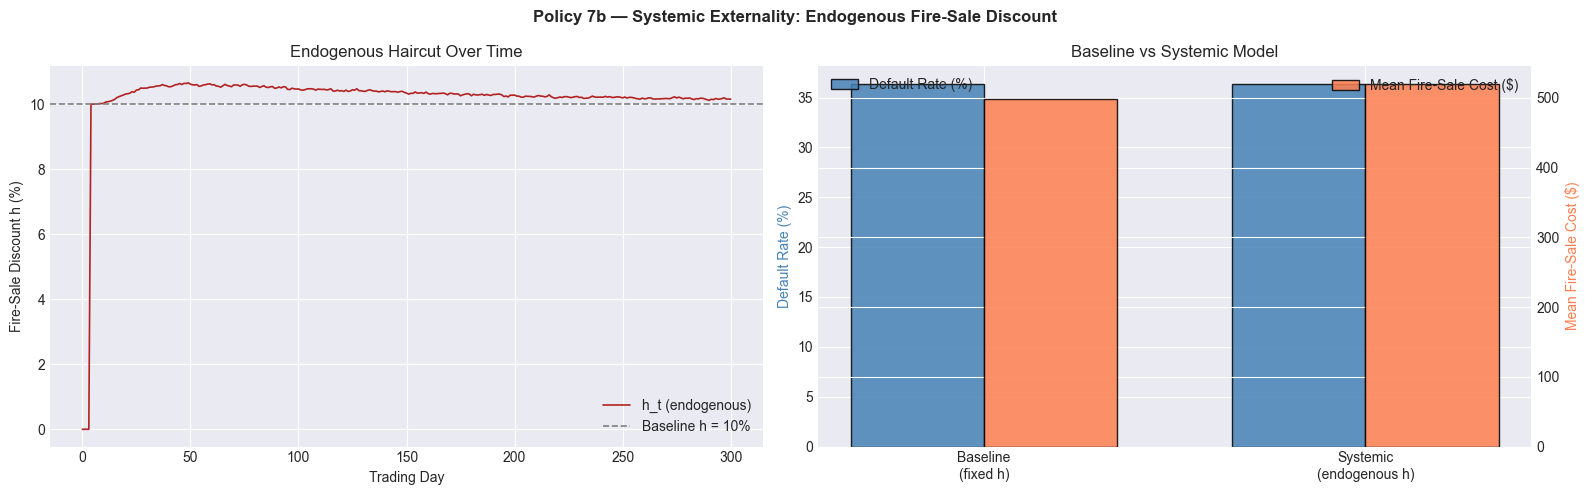

In [19]:
h0 = 0.10
theta = 2.0

defaults_sys = np.zeros((N, T_days + 1), dtype=int)
cash_sys = np.zeros((N, T_days + 1))
illiquid_sys = np.zeros((N, T_days + 1))
fire_sale_costs_sys = np.zeros(N)
h_path = np.zeros(T_days + 1)
frac_selling_path = np.zeros(T_days + 1)  # track lagged fraction fire-selling

cash_sys[:, 0] = L0 - IM
illiquid_sys[:, 0] = A0
prev_V_sys = V[:, 0]
default_time_sys = np.full(N, -1)

for t in range(1, T_days + 1):
    cash_sys[:, t] = cash_sys[:, t - 1]
    illiquid_sys[:, t] = illiquid_sys[:, t - 1]
    defaults_sys[:, t] = defaults_sys[:, t - 1]

    newly_defaulted = (defaults_base[:, t] == 1) & (defaults_sys[:, t - 1] == 0)
    defaults_sys[newly_defaulted, t] = 1
    default_time_sys[newly_defaulted & (default_time_sys == -1)] = t

    in_mpor_sys = (default_time_sys >= 0) & (t <= default_time_sys + MPOR)
    active_sys = (defaults_sys[:, t] == 0) & ~in_mpor_sys

    vm_sys = V[:, t] - prev_V_sys
    recv_sys = active_sys & (vm_sys > 0)
    cash_sys[recv_sys, t] += vm_sys[recv_sys]

    needs_pay_sys = active_sys & (vm_sys < 0)
    if needs_pay_sys.any():
        pay_sys = -vm_sys[needs_pay_sys]
        can_cash_sys = cash_sys[needs_pay_sys, t] >= pay_sys

        pc_sys = needs_pay_sys.copy(); pc_sys[needs_pay_sys] = can_cash_sys
        cash_sys[pc_sys, t] -= pay_sys[can_cash_sys]

        nfs_sys = needs_pay_sys.copy(); nfs_sys[needs_pay_sys] = ~can_cash_sys
        if nfs_sys.any():
            # Section 1.5: h driven by fraction selling in PREVIOUS period (lagged)
            frac_selling_path[t] = nfs_sys.sum() / N
            h_t = min(h0 * (1 + theta * frac_selling_path[t - 1]), 0.50)
            h_path[t] = h_t

            short_sys = pay_sys[~can_cash_sys] - cash_sys[nfs_sys, t]
            sell_sys = short_sys / (1 - h_t)
            fcost_sys = sell_sys * h_t

            fire_sale_costs_sys[nfs_sys] += fcost_sys

            cm_sys = illiquid_sys[nfs_sys, t] >= sell_sys
            meets_sys = nfs_sys.copy(); meets_sys[nfs_sys] = cm_sys
            cash_sys[meets_sys, t] = 0
            illiquid_sys[meets_sys, t] -= sell_sys[cm_sys]

            ld_sys = nfs_sys.copy(); ld_sys[nfs_sys] = ~cm_sys
            defaults_sys[ld_sys, t] = 1
            default_time_sys[ld_sys & (default_time_sys == -1)] = t

    prev_V_sys = V[:, t]

no_default_sys = (defaults_sys[:, -1] == 0)
cash_sys[no_default_sys, -1] += IM

print(f"\nEndogenous fire-sale discount: h_t = {h0:.0%} x (1 + {theta:.0f} x frac_selling_{{t-1}})")
print(f"  Max h reached: {h_path.max():.1%}  |  Mean h (fire-sale days): {h_path[h_path>0].mean():.1%}" if (h_path>0).any() else "  No fire-sales triggered.")
print(f"\n  Baseline model:  fire-sale cost ${fire_sale_costs.mean():,.2f}/path  |  defaults {100*defaults_fs[:,-1].sum()/N:.2f}%")
print(f'{"Systemic model":30s}  fire-sale cost ${fire_sale_costs_sys.mean():,.2f}/path  |  defaults {100*defaults_sys[:,-1].sum()/N:.2f}%')

# ── Charts ─────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Left: endogenous haircut time series
days_ax = np.arange(T_days + 1)
axes[0].plot(days_ax, h_path * 100, color='firebrick', linewidth=1.2, label='h_t (endogenous)')
axes[0].axhline(h0 * 100, color='grey', linestyle='--', linewidth=1.2, label=f'Baseline h = {h0:.0%}')
axes[0].set_xlabel('Trading Day')
axes[0].set_ylabel('Fire-Sale Discount h (%)')
axes[0].set_title('Endogenous Haircut Over Time')
axes[0].legend()

# Right: baseline vs systemic — default rate and fire-sale cost
labels_7b   = ['Baseline\n(fixed h)', 'Systemic\n(endogenous h)']
def_rates   = [100*defaults_fs[:,-1].sum()/N, 100*defaults_sys[:,-1].sum()/N]
fs_costs_7b = [fire_sale_costs.mean(), fire_sale_costs_sys.mean()]
x = np.arange(2); w = 0.35
bars1 = axes[1].bar(x - w/2, def_rates,   w, label='Default Rate (%)',      color='steelblue', edgecolor='black', alpha=0.85)
ax2   = axes[1].twinx()
bars2 = ax2.bar(x + w/2,    fs_costs_7b, w, label='Mean Fire-Sale Cost ($)', color='coral',     edgecolor='black', alpha=0.85)
axes[1].set_xticks(x); axes[1].set_xticklabels(labels_7b)
axes[1].set_ylabel('Default Rate (%)',       color='steelblue')
ax2.set_ylabel('Mean Fire-Sale Cost ($)',     color='coral')
axes[1].set_title('Baseline vs Systemic Model')
axes[1].legend(loc='upper left'); ax2.legend(loc='upper right')

plt.suptitle('Policy 7b — Systemic Externality: Endogenous Fire-Sale Discount', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

## 8. Key Findings

This simulator models the interaction between margin requirements and liquidity constraints in OTC derivatives markets. The main results are:

**1. The IM/liquidity trade-off is real and steep.**
Increasing the IM multiplier from 1× to 2× materially reduces Dealer losses but raises liquidity defaults and fire-sale costs. There is no free lunch — tighter margins transfer risk from Dealer to Investor.

**2. Liquidity-driven defaults add significantly to base credit risk.**
Even with only 1% annual exogenous default probability, a constrained balance sheet generates additional defaults purely from VM cash-flow pressure — amplifying the total default rate well beyond the credit-only baseline.

**3. VM frequency is a two-sided lever.**
Weekly settlement reduces the number of funding events but concentrates exposure into larger lump-sum calls, increasing both peak liquidity demand and the Dealer's accumulated exposure between settlements.

**4. Accepting illiquid collateral shifts risk, it does not eliminate it.**
Allowing the Investor to pledge assets removes fire-sale costs, but the Dealer inherits illiquid assets it must liquidate at the same haircut on default. Systemic risk is redistributed, not reduced.

**5. Procyclical IM is a self-reinforcing amplifier.**
Recalculating IM from current stressed volatility doubles the margin requirement during downturns, draining Investor cash exactly when prices are already falling. Through-the-cycle (TTC) IM avoids this at the cost of slightly underestimating risk in calm periods — the regulatory compromise embedded in EMIR and UMR rules.

**6. Simultaneous fire-sales create liquidity spirals.**
Endogenous haircuts driven by aggregate selling pressure amplify both fire-sale costs and default rates beyond what any individual institution's risk model would project — the core macroprudential concern motivating system-wide margin reform after 2008.

---
*Built with NumPy · SciPy · Matplotlib · Pandas — 10,000 Monte Carlo paths · 300 trading days · arithmetic Brownian motion*